In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vtk

plt.style.use('default')

In [3]:
position_file_location = 'rank_0_positions.txt'

with open(position_file_location, 'r') as file:
    
    file.readline()  # Skip the line with the number of nodes
    file.readline()  # Skip the min/max lines
    file.readline()  # Skip the min/max lines
    file.readline()  # Skip the empty line
        
    positions = []
    labels = []
    types = []
        
    for line in file:
        # Skip lines that start with "Maximum" or "Minimum" or any comment lines
        if line.startswith("Maximum") or line.startswith("Minimum") or line.startswith("#"):
            continue
                
        # Split the line by spaces
        parts = line.split()
            
        # Ensure the line has the correct number of parts
        if len(parts) >= 6:
            x, y, z = map(float, parts[1:4])
            area = parts[4]
            neuron_type = parts[5]
                    
            positions.append([x, y, z])
            labels.append(area)
            types.append(neuron_type)
    
    positions = np.array(positions)

/var/folders/1s/s3n0mk7s45n_8bvs1l6047sc0000gp/T/ipykernel_29705/2378537038.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_areas))


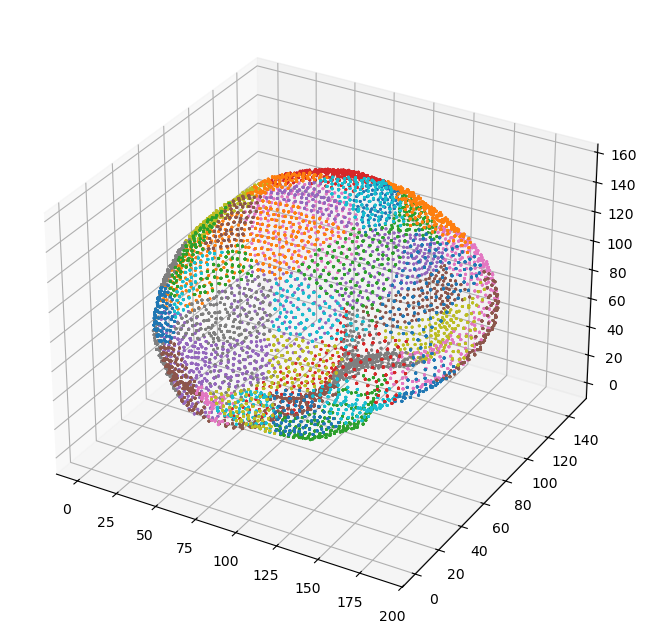

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_areas = list(set(labels))
colors = plt.cm.get_cmap('tab10', len(unique_areas))
area_color_map = {area: colors(i) for i, area in enumerate(unique_areas)}

node_colors = [area_color_map[area] for area in labels]

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=node_colors, s=1)

plt.show()

In [5]:
column_headers_pos = ['local id', 'pos x', 'pos y', 'pos z', 'area', 'type']

df_pos = pd.read_csv('rank_0_positions.txt', skiprows= 8, delimiter=' ', names=column_headers_pos)
df_pos.head()


,local id,pos x,pos y,pos z,area,type
0,1,88.017654,143.88911,83.259131,area_43,ex
1,2,88.071787,143.79220,83.237149,area_43,ex
2,3,88.093434,143.95190,83.168331,area_43,ex
3,4,88.063898,143.81981,83.317563,area_43,ex
4,5,88.066131,143.97354,83.238470,area_43,ex


In [6]:
column_headers_network = ['target rank', 'target ID', 'source rank', 'source ID', 'weigth']

df_nw = pd.read_csv('rank_0_step_40000_in_network.txt', skiprows= 5, delimiter=r'\s+', names=column_headers_network)
df_nw.head()


,target rank,target ID,source rank,source ID,weigth
0,0,1,0,657,1
1,0,3,0,4757,1
2,0,3,0,1824,1
3,0,4,0,384,1
4,0,5,0,1624,1


In [ ]:
graph = vtk.vtkMutableUndirectedGraph()

positions = vtk.vtkPoints()

for ix, id in enumerate(df_pos['local id']):
    id = graph.AddVertex()
    
    positions.InsertNextPoint(df_pos.loc[id]['pos x'], df_pos.loc[id]['pos y'], df_pos.loc[id]['pos z'] )

graph.SetPoints(positions)


In [10]:
# Create a layout (pass-through since we already set positions)
layout = vtk.vtkGraphLayout()
layout.SetInputData(graph)
layout.SetLayoutStrategy(vtk.vtkPassThroughLayoutStrategy())  # Preserve manual positions

# Set up rendering
layout_view = vtk.vtkGraphLayoutView()
layout_view.AddRepresentationFromInputConnection(layout.GetOutputPort())
layout_view.ResetCamera()

# Render the graph
render_window = layout_view.GetRenderWindow()
render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)
layout_view.GetRenderer().SetBackground(0.1, 0.2, 0.3)  # Set background color
render_window.Render()

# Start interaction
render_window_interactor.Start()

2024-11-25 12:48:22.870 python[29705:13316499] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-25 12:48:22.870 python[29705:13316499] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
